# Extended interactions in 1D
Consider an extended Hubbard model in dimension 1 with a local interaction $U$, and first-neighbor hopping term $-t$ and a first-neighbor interaction $V$.
Construct a 4-site cluster to represent this system, with a Hartree mean field $V_m$ designed to represent the effect of the inter-cluster part of the extended interaction (see documentation on the Hartree approximation).
Construct also an operator $\hat\Delta$ reprensenting a site-centered charge density wave of period 2:
$$ \hat\Delta = \sum_i (-1)^i n_i  $$
In this problem we will stay at half-filling, where the chemical potential can be shown to be $\mu=U/2+2V$. We will set $U=4$ and $t=1$.

- This part is purely theoretical. Show that, in the $t\to 0$ limit, the system develops a spontaneous charge density wave if $V>V_c = U/2$.
Does this critical value of $V$ change if $t$ is no longer zero? If so, in what direction?

- In the absence of charge density wave, find the optimal value of the Hartree field $V_m$ as a function of $V$ in the range $V\in[0,U]$.
For this, proceed by using the self-consistency condition and the function $\texttt{pyqcm.loop.Hartree()}$.

- Redo the above, this time using the VCA with the coefficient of $V_m$ as a variational parameter (this is a lattice, not a cluster parameter).
Beware of the keyword argument $\texttt{hartree}$ in the function $\texttt{vca()}$; it is crucial.

- Using as an \textit{additional} variational parameter the coefficient of $\hat\Delta$ (this is a cluster, not a lattice parameter), find how the charge density wave develops as a function of $V$ in the interval $V\in[3,4]$. It is easier for this to loop down from $V=4$ and to start with the
appropriate value of $V_m$ as a starting value. A quick $\texttt{plot\_sef()}$ may be useful here to find an appropriate starting value of $\Delta$.
Make a plot of the order parameter $\langle\hat\Delta\rangle$ as a function of $V$. You should find here a confirmation to your answer to the last question raised in part A.


In [1]:
import pyqcm
from pyqcm.vca import VCA
import numpy as np

import matplotlib.pyplot as plt

# A simple 1D 4 site cluster
CM = pyqcm.cluster_model( 4, 0)
clus = pyqcm.cluster(CM, ((0,0,0),(1,0,0),(2,0,0),(3,0,0)))
model = pyqcm.lattice_model('1D_4', clus, ((4,0,0),))

Number of OpenMP threads = 8


### A note on $V_m$

Since the sites on either end of the cluster are the only ones that will feel the effect of inter-cluster interactions the components of $V^m_{ij}$ where $i$ and $j$ are site indices are:
$$
    V^m_{ij} \propto
    \begin{pmatrix}
        0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 \\
        1 & 0 & 0 & 0
    \end{pmatrix}
$$
This matrix admits $1$, $-1$ and $0$ twice as eigenvalues, but only the first two ones are physically interesting.

In [2]:
model.interaction_operator('U', amplitude=1) # on site interaction
model.interaction_operator('V', link=(1,0,0), amplitude=1) # NN interaction
model.hopping_operator('t', [1,0,0], -1) 
model.density_wave('Delta', 'N', (1,0,0), amplitude=1) # A charge density wave with period 2 in position space

# Defining an explicit operator for the "Hartree part" of the extended interaction
elems = [((0,0,0), (0,0,0), 1/np.sqrt(2)), ((3,0,0), (0,0,0), 1/np.sqrt(2))] # the 1/sqrt(2) factor ensures normalization
model.explicit_operator('Vm1', elems, type='one-body', tau=0) # Vm is an on-site operator ---> tau=0

elems = [((0,0,0), (0,0,0), 1/np.sqrt(2)), ((3,0,0), (0,0,0), -1/np.sqrt(2))] # the 1/sqrt(2) factor ensures normalization
model.explicit_operator('Vm2', elems, type='one-body', tau=0) # Vm is an on-site operator ---> tau=0

In [3]:
# Parameters required for half-filling
model.set_target_sectors('R0:N4:S0')
model.set_parameters("""
    U=4
    V=4
    Vm1=5
    mu=10
    t=1
    Delta_1=1e-9
    Delta=1e-9
""")
I = pyqcm.model_instance(model)

In [4]:
# Defining an object of the hartree class with eigenvalue 1
MF1 = pyqcm.hartree(model, 'Vm1', 'V', 1, accur=1e-2, lattice=True) # lattice=True ---> use lattice averages

In [5]:
#########################################################################################
############################## - Range for sweep over V - ###############################

V_start = 1e-9
V_stop = 4
V_step = 0.1
U = model.parameters()['U']

#########################################################################################
############################# - Self-consistency approach - #############################

# This is simply a loop that applies the self_consistency approach over V_range

def F():
    model.set_parameter('V', V)
    model.set_parameter('mu', 2*V + U/2) # Condition to impose half-filling
    return pyqcm.model_instance(model)

for V in np.arange(V_start, V_stop, V_step):
    model.Hartree_procedure(F, MF1, maxiter=32)

#########################################################################################
################################### - VCA approach - ####################################

# This is the function to run inside of controlled_loop to perform the vca itself
def run_vca():
    V = model.parameters()['V']
    model.set_parameter('mu', 2*V + U/2) # Condition to impose half-filling
    V = VCA(model, varia='Vm1', steps=0.05, accur=2e-3, max=20, hartree=MF1, max_iter=64)    
    return V.I

# performing the vca loop over V_range
model.controlled_loop(run_vca, varia='Vm1', loop_param='V', loop_range=(V_start, V_stop, V_step))

#########################################################################################
################################### - Reading data - ####################################

V_grid_size = int(np.abs(V_stop - V_start//V_step) + 1)

d_vca = np.genfromtxt("./vca.tsv", usecols=[6, 7]) # getting V and Vm
d_vca = d_vca[-V_grid_size:] # reading the relevant vca results

d_hartree = np.genfromtxt("./hartree.tsv", usecols=[5, 6]) # getting V and Vm
d_hartree = d_hartree[-V_grid_size:] # reading the relevant vca results


**************************************** Hartree procedure ****************************************

--------------------------------------- Hartree iteration 1 ---------------------------------------
<Vm1> = 0.374405	Vm1 = 3.74405e-10 (diff = -5, 4.99813e+08%)
total difference = 5
--------------------------------------- Hartree iteration 2 ---------------------------------------
<Vm1> = 1.41421	Vm1 = 1.41421e-09 (diff = 1.03981e-09, 0.103834%)
total difference = 1.03981e-09
********************************* Hartree procedure has converged *********************************

**************************************** Hartree procedure ****************************************

--------------------------------------- Hartree iteration 1 ---------------------------------------
<Vm1> = 1.42245	Vm1 = 0.142245 (diff = 0.142245, 99.9993%)
total difference = 0.142245
--------------------------------------- Hartree iteration 2 ---------------------------------------
<Vm1> = 1.41417	Vm1 = 0.141417

### Comparing the self-consistency approach to the VCA approach

As can be seen in the plot below, both approaches for calculating $V_m$ as a function of $V$ yield identical results.

/var/folders/l5/bpxk4jj97_34g93z1yf582m80000gq/T/ipykernel_85981/4276858632.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


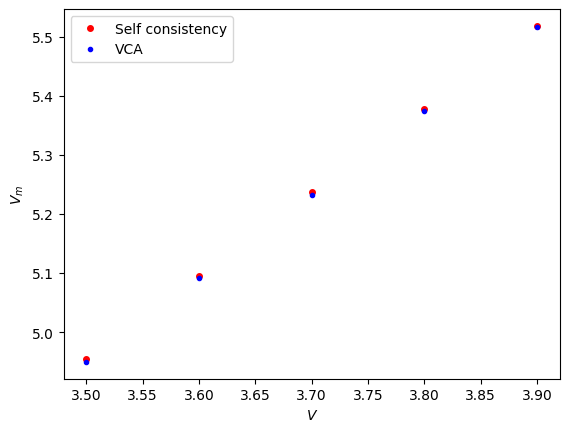

In [6]:
# Plotting V_m as a function of for both approaches
fig, ax = plt.subplots()

ax.plot(d_hartree[:,0], d_hartree[:,1], 'o', color="red", markersize=4, label="Self consistency")
ax.plot(d_vca[:,0], d_vca[:,1], 'o', color="blue", markersize=3, label="VCA")

ax.set_xlabel("$V$")
ax.set_ylabel("$V_m$")

ax.legend()

fig.show()

global parameter accur_SEF set to 0.0001
omega( -2.0 ) =  -7.375258300922153
omega( -1.979899497487437 ) =  -7.375608670894611
omega( -1.9597989949748744 ) =  -7.3759613455323745
omega( -1.9396984924623115 ) =  -7.376316346943708
omega( -1.9195979899497488 ) =  -7.376673697520825
omega( -1.899497487437186 ) =  -7.377033419929069
omega( -1.879396984924623 ) =  -7.377395537118791
omega( -1.8592964824120604 ) =  -7.37776007232586
omega( -1.8391959798994975 ) =  -7.378127049074629
omega( -1.8190954773869348 ) =  -7.378496491173872
omega( -1.7989949748743719 ) =  -7.378868422752676
omega( -1.778894472361809 ) =  -7.379242868230172
omega( -1.7587939698492463 ) =  -7.379619852327759
omega( -1.7386934673366834 ) =  -7.3799994000834515
omega( -1.7185929648241207 ) =  -7.380381536845173
omega( -1.6984924623115578 ) =  -7.380766288302464
omega( -1.678391959798995 ) =  -7.381153680436552
omega( -1.6582914572864322 ) =  -7.381543739590163
omega( -1.6381909547738693 ) =  -7.381936492414277
omega( -1

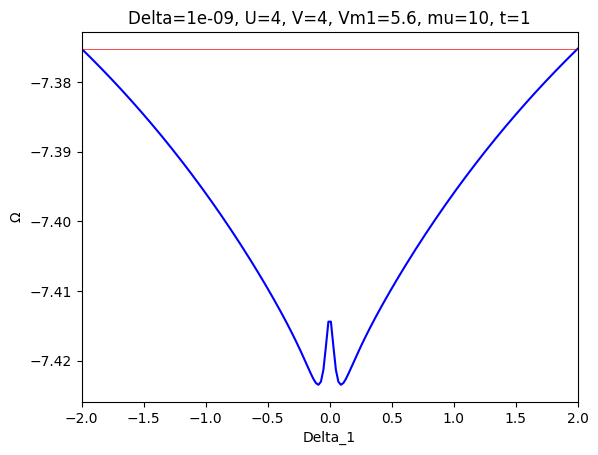

In [7]:
# Plotting the Potthoff functionnal as a function of Delta to find a starting value
V = 4
U = 4
model.set_parameter("V", V)
model.set_parameter("Vm1", 5.6) # Based on previous results
model.set_parameter('mu', 2*V + U/2) # Condition to impose half-filling
Delta_grid = np.linspace(-2, 2, 200)
pyqcm.vca.plot_sef(model, "Delta_1", Delta_grid, hartree=[MF1]) 

In [8]:
# Function to perform the VCA
varia=('Vm1', 'Delta_1')
def run_vca_2():
    V = model.parameters()['V']
    model.set_parameter('mu', 2*V + U/2) # Condition to impose half-filling
    V = VCA(model, varia=varia, steps=0.05, accur=2e-3, max=20, hartree=MF1, max_iter=64)    
    return V.I

# Looping from 4 to 3
# model.controlled_loop(run_vca_2, varia=varia, loop_param='V', loop_range=(V_start, V_stop, V_step))

#########################################################################################
######################### - Hybrid VCA with self-consistency - ##########################

def run_vca_3():
    V = model.parameters()['V']
    model.set_parameter('mu', 2*V + U/2) # Condition to impose half-filling
    V = VCA(model, varia='Delta_1', steps=0.05, accur=2e-3, max=20, max_iter=64, hartree= MF1, hartree_self_consistent=True)    
    return V.I

try:
    model.controlled_loop(run_vca_3, varia=('Delta_1', 'Vm1'), loop_param='V', loop_range=(V_start, V_stop, V_step))
except:
    pass


#########################################################################################
################################### - Reading data - ####################################

V_grid_size = int(np.abs((V_stop - V_start)//V_step) + 1) # Number of grid points from 4 to 3
#V_grid_size_2 = int(np.abs((V_stop_2 - V_start_2)//V_step_2) + 1) # Number of grid points from 4 to 5

raw_vca_data = np.genfromtxt("./vca.tsv", delimiter="\t", usecols=[6, 4]) # getting V and Delta

# Selecting data according to whether the range over V is [3,4] or [3,5]
if LOOP_UP is True:
    d_varia = raw_vca_data[-2*V_grid_size-2*V_grid_size_2:-V_grid_size-V_grid_size_2] # getting 2 param VCA data from V = [3,5]
    d_self_consis = raw_vca_data[-V_grid_size-V_grid_size_2:] # getting hybrid VCA data from V = [3,5]
else:
    d_varia = raw_vca_data[-2*V_grid_size:-V_grid_size] # getting 2 param VCA data from V = [3,4]
    d_self_consis = raw_vca_data[-V_grid_size:] # getting hybrid VCA data from V = [3,4]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% controlled loop over V %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


==================================== loop index = 1, V = 0.0000 ====================================

******************** VCA procedure, (combined with Hartree procedure) method NR ********************
Delta_1   =  2	
x =  [ 2.]
x =  [ 2.05]
x =  [ 1.95]
effective VCA precision:  [ 0.002418]
delta Vm1 = -5.6 ( 5.6e+08%) 
NR iteration no  1 	 x =  [ 6.327965] 	 steps =  [4.3279645747493145] 	 dx =  [ 4.327965]
x =  [ 6.327965]
x =  [ 10.655929]
x =  [ 2.]
effective VCA precision:  [ 0.002241]
delta Vm1 = 1.1e-09 ( 0.11%) 
NR iteration no  2 	 x =  [ 8.827841] 	 steps =  [2.499876255389051] 	 dx =  [ 2.499876]
x =  [ 8.827841]
x =  [ 11.327717]
x =  [ 6.327965]
effective VCA precision:  [ 0.000755]
delta Vm1 = 7.83e-20 ( 7.82e-12%) 
NR iteration no  3 	 x =  [ 11.530625] 	 steps =  [2.702784057889914] 	 dx =  [ 2.702784]
x =  [ 11.530625]
x =  [ 14.233409]
x =  [ 8.827841]
effective V

NameError: name 'LOOP_UP' is not defined

### Comparing the hybrid Hartree self-consistent VCA to the two parameter VCA

In this case, the results are very similar, but not as close as for the previous comparison.

NameError: name 'd_self_consis' is not defined

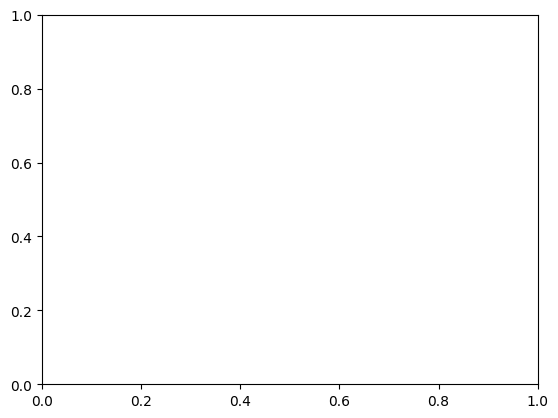

In [ ]:
# Plotting both VCA approaches
fig, ax = plt.subplots()

ax.plot(d_self_consis[:,0], d_self_consis[:,1], 'o', color="red", markersize=4, label="Self consistency")
ax.plot(d_varia[:,0], d_varia[:,1], 'o', color="blue", markersize=3, label="VCA")

ax.set_xlabel("$V$")
ax.set_ylabel("$\langle\Delta\\rangle$")

ax.legend()

fig.show()

### Spontaneous charge density formation

In the $t\to0$ limit, the hamiltonian can be written as:
$$
    H = U + V - \mu\hat N = U\sum_i n_{i\uparrow}n_{i\downarrow} + V\sum_i n_{i}n_{i+1} - \mu\sum_i n_{i}
$$
Consider a charge density wave configuration at half-filling with site occupations
$$ n_i = 1 + (-1)^i $$
Every other site, there is a contribution of $U$ and $-2\mu$ to the energy but there is obviously no first-neighbor interaction terms contributing. The energy per site is therefore: 
$$\epsilon_{\text{cdw}} = \frac{U}{2} - \mu$$
In the case of a uniform distribution of electrons at half-filling, the site occupation is trivially $n_i=1$.
In this case there is a contribution of $V$ and $-\mu$ every site but not from on-site interactions. Therefore
$$ \epsilon_{\text{normal}} = V - \mu$$
For a spontaneous CDW to develop, the energy of a uniform system must be greater than that of the charge density wave created. This condition is simply stated as:
\begin{align*}
    \epsilon_{\text{normal}} &> \epsilon_{\text{cdw}} \\
    V_c - \mu &> \frac{U}{2} - \mu\\
    V_c &> \frac{U}{2}
\end{align*}
The critical value $V_c$ for which a charge density wave can spontaneously arise is $V_c = U/2$. Of course, if $t$ is not trivial, $V_c$ will increase since kinetic energy has a tendency to spread out the electrons more evenly, thus requiring a stronger $V$ to overcome this effect.